In [1]:
"""
This code list implement the Monte Carlo Policy Gradient Alogrithm.
------------------------------------------------------------------
Input:
    differentiable policy function $\pi_{\theta}(a|s)$

Initalize:
    Parameter $\theta$ for policy function

Repeat  experience trajectory:
    Use $\pi_{\theta}(a|s)$ to generate one trajectory $(s_0,a_0,r_1....s_T)$
    Repeat each step in trajectory:
        G <--- cumlated reward at time step t
        Calculate the policy gradient  $\Delta\theta_t = \alpha \Delta_{\theta}log\pi_{\theta}(s_t, a_t)G_t$
------------------------------------------------------------------
"""
import time
import pandas as pd
import gym
import os 
import sys
import numpy as np
from collections import defaultdict, namedtuple
from keras.layers.core import Dense, Dropout, Activation
import keras.backend as K
from keras import models,layers,optimizers
from keras.utils import np_utils
import matplotlib
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [2]:
RENDER_ENV = False
LEARNING_RATE = 0.02
REWARD_DECAY = 0.99
OUTPUT_GRAPH = False
ENVNAME = "CartPole-v0"
HIDDEN_UNITS =[20, 20]
NUM_EPISODES = 200
ACTIVATION_FUNCTION = "tanh"

In [3]:
class MCPG():
    def __init__(self, 
                 n_action, 
                 n_feature, 
                 learning_rate=0.01, 
                 reward_decay=0.95, 
                 ouput_graph=False,
                ):
        self.n_action = n_action
        self.n_features = n_feature
        self.gamma = reward_decay
        self.learning_rate = learning_rate
        self.episode_observation = []
        self.episode_actions = [] 
        self.episode_rewards = []
        self.__build__network()
        self.__train_network()
        
        
    def __build__network(self):
        self.input_observation = layers.Input(shape=(self.n_features,))
        net = self.input_observation
        
        for h_dim in HIDDEN_UNITS:
            net = layers.Dense(h_dim)(net)
            net = layers.Activation(ACTIVATION_FUNCTION)(net)
            
        net = layers.Dense(self.n_action)(net)
        net = layers.Activation("softmax")(net)
        self.model = models.Model(inputs=self.input_observation, outputs=net)
        self.model.summary()
        
    def __train_network(self):
        action_prob_placeholder = self.model.output
        action_onehot_placeholder = K.placeholder(shape=(None, self.n_action),
                                                 name="action_onehot")
        discount_reward_placeholder = K.placeholder(shape=(None,),
                                                   name="discount_reward")
        action_prob = K.sum(action_prob_placeholder * action_onehot_placeholder, axis=1)
        log_action_prob = K.log(action_prob)
        
        loss = -log_action_prob*discount_reward_placeholder
        loss = K.mean(loss)
        
        adam = optimizers.Adam(lr=LEARNING_RATE)
        updates = adam.get_updates(params=self.model.trainable_weights,
                                    loss=loss)
        self.train_fn = K.function(inputs=[self.model.input,
                                          action_onehot_placeholder,
                                          discount_reward_placeholder],
                                   outputs=[self.model.output],
                                   updates=updates)
        
    def choose_action(self, observation):
        feed_state = observation[np.newaxis,:]
        prob_weights = self.model.predict(feed_state)
        action = np.random.choice(range(prob_weights.shape[1]),
                                 p=prob_weights.ravel())
        return action
    
    def store_transistion(self, s, a, r):
        self.episode_observation.append(s)
        self.episode_actions.append(a)
        self.episode_rewards.append(r)

    def learn(self):
        #discount and normalize the episode reward
        discounted_episode_reward_normalized = self._discount_and_norm_rewards()
        action_onehot = np_utils.to_categorical(self.episode_actions,
                                               num_classes=self.n_action)
        
        self.train_fn([np.vstack(self.episode_observation), action_onehot,
                       discounted_episode_reward_normalized])
        
        self.episode_observation = []
        self.episode_actions = [] 
        self.episode_rewards = []
        return discounted_episode_reward_normalized
    
    def _discount_and_norm_rewards(self):
        discounted_episode_reward = np.zeros_like(self.episode_rewards)
        running_add = 0
        for t in reversed(range(0, len(self.episode_rewards))):
            running_add = running_add * self.gamma + self.episode_rewards[t]
            discounted_episode_reward[t] = running_add
        
        # normalized
        discounted_episode_reward -= np.mean(discounted_episode_reward)
        discounted_episode_reward /= np.std(discounted_episode_reward)
        return discounted_episode_reward        

In [4]:
def plot_episode_stats1(rec, xlabel, ylabel,title):
    fig = plt.figure(figsize=(20, 10), facecolor = "white")
    ax = fig.add_subplot(111)
    ax.plot(rec) 
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    return fig

def plot_episode_stats2(stats):
    # Plot time steps and episode number
    fig3 = plt.figure(figsize=(20, 10))
    plt.plot(np.cumsum(stats.episode_lengths), np.arange(len(stats.episode_lengths)))
    plt.xlabel("Time Steps")
    plt.ylabel("Episode")
    plt.title("Episode per time step")
    return fig3

def Plot_the_result(rec):
    # Plot episode length over time
    episode_lengths = rec.episode_lengths
    fig = plot_episode_stats1(episode_lengths, 
                       xlabel = "Episode",
                       ylabel = "Episode Length",
                       title = "Episode length over Time"
            )
    fig.show()
    fig.savefig("./log/MCPG_keras_CartPole_EpisodeLength.jpg")

    # Plot Episode reward over time
    smoohing_window = 10
    reward_smooths = pd.Series(rec.episode_rewards).rolling(smoohing_window,\
                    min_periods = smoohing_window).mean()
    fig = plot_episode_stats1(reward_smooths, 
                       xlabel = "Episode",
                       ylabel = "Episode Reward",
                       title = "Episode reward over time"
            )
    fig.show()
    fig.savefig("./log/MCPG_keras_CartPole_EpisodeReward.jpg")
    
    # Plot Episode per time step
    fig = plot_episode_stats2(rec)
    fig.show()
    fig.savefig("./log/MCPG_keras_CartPole_EpisodePerTimeStep.jpg")

In [5]:
def update(RL, env, num_episodes):
    # Track the statistics of the result
    record = namedtuple("Record", ["episode_lengths","episode_rewards"])
    
    rec = record(episode_lengths=np.zeros(num_episodes),
                          episode_rewards=np.zeros(num_episodes))
    
    for i_episode in range(num_episodes):
        if 0 == (i_episode +1) % 1:
            print("This the episode {}/{}".format(i_episode, num_episodes), end = "\r")
        observation = env.reset()
        step =0
        reward_cum = 0
        done = False
        while True:
            #env.render()
            if RENDER_ENV:
                env.render()
            # step1: choose action based on the state
            action = RL.choose_action(observation)
            # step2: take the action in the enviroment
            observation_next, reward, done, info = env.step(action)
            # step3: store the transistion for training
            RL.store_transistion(observation, action, reward)
            # update the record
            step += 1
#            if step % 10000 == 0:
#                print("step is:",step)
            rec.episode_lengths[i_episode] = step 
            rec.episode_rewards[i_episode] += reward
            if done or rec.episode_rewards[i_episode] > 2000:
                # step4: train the network
                RL.learn()
                print("The reward at episode {} is {}.".format(i_episode, 
                                                              rec.episode_rewards[i_episode]))
                break
            # step5: save the new state
            observation = observation_next
    print("Finished")
    env.close()
    return rec

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                100       
_________________________________________________________________
activation_1 (Activation)    (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                420       
_________________________________________________________________
activation_2 (Activation)    (None, 20)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 42        
_________________________________________________________________
activation_3 (Activation)    (None, 2)                 0   

The reward at episode 186 is 2001.0.
The reward at episode 187 is 2001.0.
The reward at episode 188 is 2001.0.
The reward at episode 189 is 2001.0.
The reward at episode 190 is 2001.0.
The reward at episode 191 is 2001.0.
The reward at episode 192 is 2001.0.
The reward at episode 193 is 2001.0.
The reward at episode 194 is 2001.0.
The reward at episode 195 is 2001.0.
The reward at episode 196 is 2001.0.
The reward at episode 197 is 2001.0.
The reward at episode 198 is 2001.0.
The reward at episode 199 is 2001.0.
Finished


/home/jabes/.local/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/jabes/.local/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/jabes/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


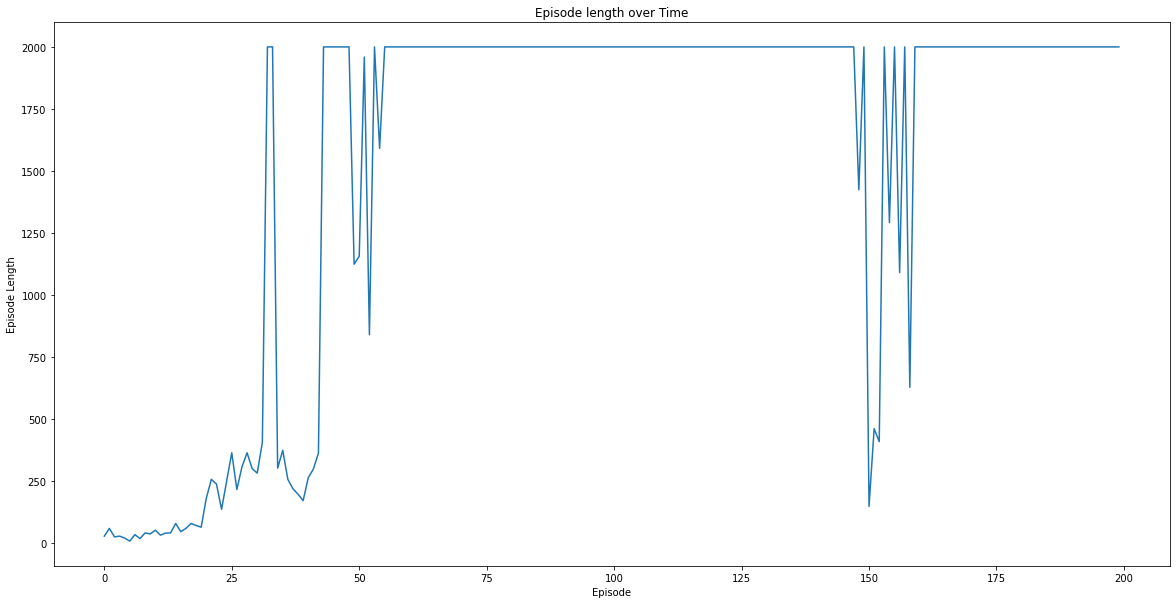

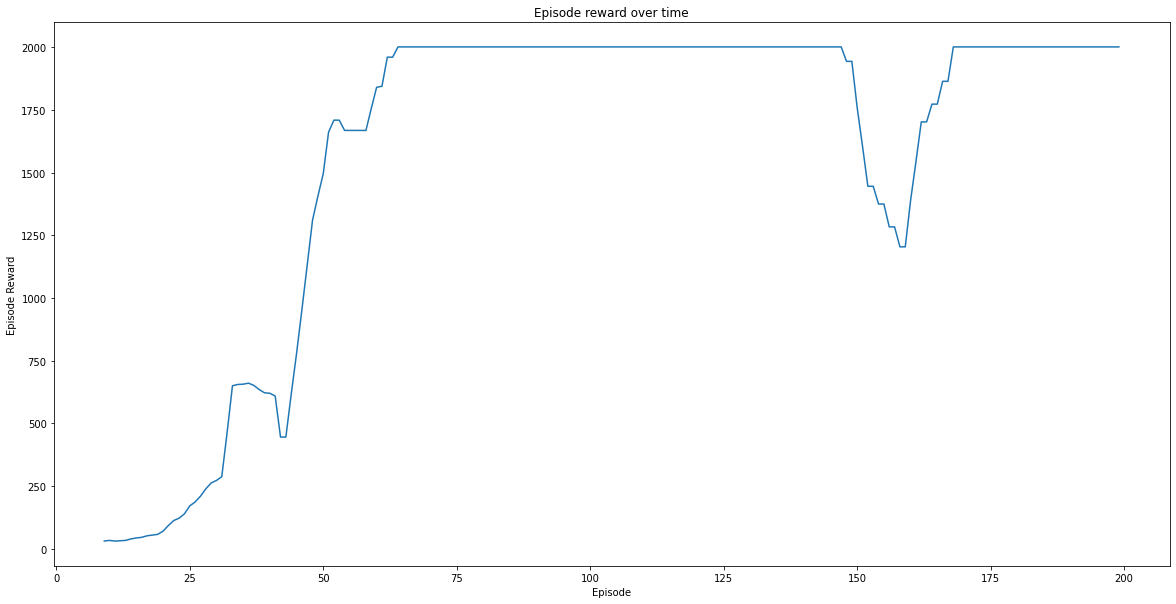

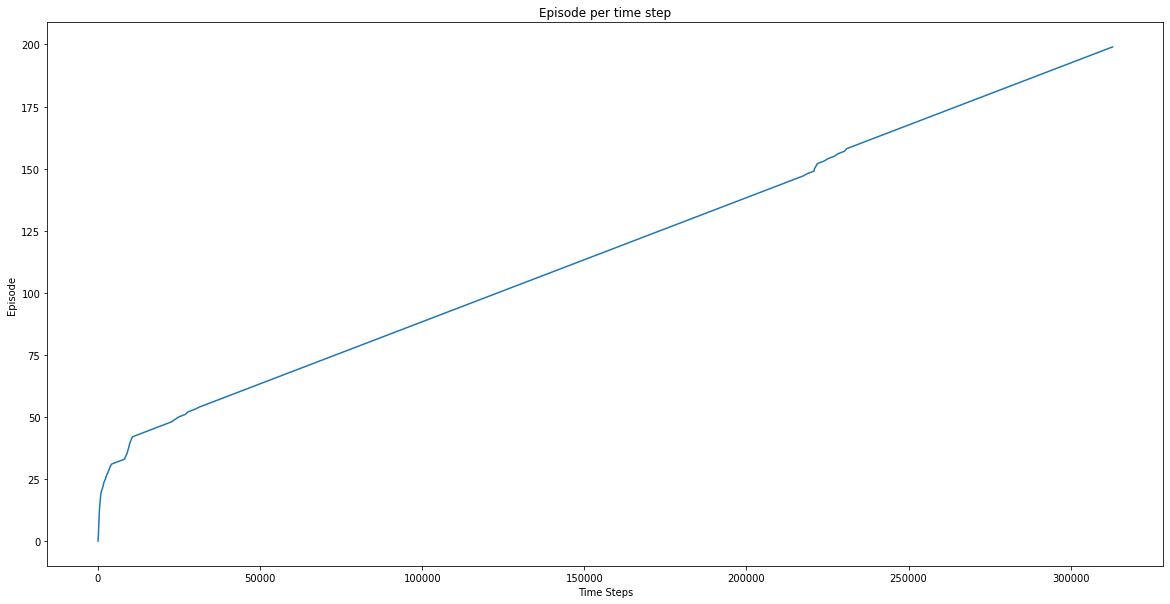

In [6]:
if __name__ == "__main__":
    env = gym.make(ENVNAME)
    env = env.unwrapped
    RL = MCPG(n_action=env.action_space.n,
             n_feature=env.observation_space.shape[0],
             learning_rate=LEARNING_RATE,
             reward_decay=REWARD_DECAY,
             ouput_graph=OUTPUT_GRAPH)
    rec = update(RL, env, num_episodes=NUM_EPISODES)
    #Plot the result
    Plot_the_result(rec)